In [1]:
!pip install --user -r requirements.txt

In [2]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
from wettbewerb import load_references, get_3montages
import mne
from scipy import signal as sig
import ruptures as rpt

In [5]:
# training_folder = "../shared_data/training_mini"
training_folder = "./mini_mat_wki"

In [6]:
ids, channels, data, sampling_frequencies, reference_systems, eeg_labels = load_references(training_folder) # Importiere EKG-Dateien, zugehörige Diagnose, Sampling-Frequenz (Hz) und Name (meist fs=256 Hz)
# print(reference_systems,eeg_labels)


100	 Dateien wurden geladen.


In [5]:
idx_record = 93 
print("IDs[0:3]: ",ids[:3])
print("Verfügbare Kanäle:",channels[idx_record])
print("Abtastrate: ", sampling_frequencies[idx_record],"Hz")
print("Referenzsystem: ", reference_systems[idx_record])
print("EEG Labels: (seizure_present, onset, offset)", eeg_labels[idx_record])

IDs[0:3]:  ['aaaaaaac_s001_t000', 'aaaaaaac_s001_t001', 'aaaaaaac_s002_t000']
Verfügbare Kanäle: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
Abtastrate:  400 Hz
Referenzsystem:  AR
EEG Labels: (seizure_present, onset, offset) (1, 34.8275, 63.0425)


In [6]:
# Berechne Montagen der linken und rechten Gehirnhälfte für die erste Aufnahme
new_montage, new_data, is_missing = get_3montages(channels[idx_record], data[idx_record])
print("Alle Montagen wurden berechnet: ", not is_missing)
print("Montagen: ",new_montage)
print("Signal Dimension: ", new_data.shape)

Alle Montagen wurden berechnet:  True
Montagen:  ['Fp1-F3', 'Fp2-F4', 'C3-P3']
Signal Dimension:  (3, 106000)


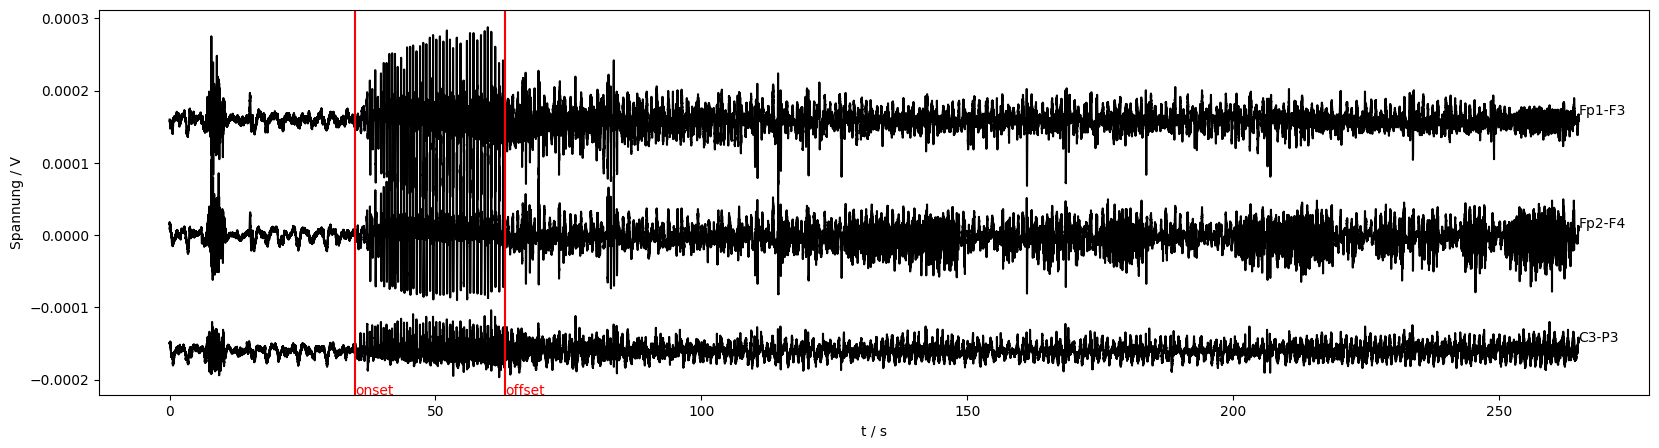

In [7]:
# Wir schauen die drei Montagen an
fig, axs = plt.subplots(figsize=[20,5])
max_diff=new_data.max()-new_data.min()
time_ax = np.arange(new_data.shape[1])/sampling_frequencies[idx_record]
_off_sets = [max_diff/1.5,0,-max_diff/1.5]
_labels = eeg_labels[idx_record]

for i, _montage in enumerate(new_montage):
    plt.plot(time_ax,new_data[i,:]+_off_sets[i],'k')
    plt.text(time_ax[-1], new_data[i,-1]+_off_sets[i], _montage)
if _labels[0]:
    plt.axvline(x = _labels[1], color = 'r', label = 'onset')
    plt.text(_labels[1], axs.get_ylim()[0], 'onset',color='r')  
    plt.axvline(x = _labels[2], color = 'r', label = 'offset')
    plt.text(_labels[2], axs.get_ylim()[0], 'offset',color='r')   
plt.xlabel("t / s")
plt.ylabel("Spannung / V")
plt.show()

In [8]:
onset_list_predict = []
onset_list = []
seizure_id_list = []

E_Zxx = []
t = []

# Setze die Segmentlänge auf z.B. 2s
window = 256*2

for i,_id in enumerate(ids):
    _fs = sampling_frequencies[i]
    _eeg_signals = data[i]
    _eeg_label = eeg_labels[i]
    if _eeg_label[0]:
        onset_list.append(_eeg_label[1])
        seizure_id_list.append(_id)
        # Berechne Montage
        _montage, _montage_data, _is_missing = get_3montages(channels[i], _eeg_signals)
        for j, signal_name in enumerate(_montage):
            # Ziehe erste Montage des EEG
            signal = _montage_data[j]
            # Wende Notch-Filter an um Netzfrequenz zu dämpfen
            signal_notch = mne.filter.notch_filter(x=signal, Fs=_fs, freqs=np.array([50.,100.]), n_jobs=2, verbose=False)
            # Wende Bandpassfilter zwischen 0.5Hz und 70Hz um Rauschen aus dem Signal zu filtern
            signal_filter = mne.filter.filter_data(data=signal_notch, sfreq=_fs, l_freq=0.5, h_freq=70.0, n_jobs=2, verbose=False)
            # Berechne Energie der Abschnitte mittels der Signalamplitude
            # Leere Listen, welche als Zwischenspeicher pro Signal verwendet werden
            t.clear()
            E_Zxx.clear()
            # Berechne Anzahl an Segmenten n
            n = len(signal) // window
            # Iteriere über alle Segmente
            for k in range(n + 1):
                # Segment aus Signal ausschneiden 
                part = signal[(k * window):((k + 1) * window)]
                # Berechne Energie dieses Teils
                energy = np.sum(part ** 2) / _fs
                # Zur Liste mit den Energie pro Segment hinzufügen
                E_Zxx.append(energy)
                # Beginn des Segments zur Liste mit Zeitpunkten hinzufügen
                t.append((k * window) / _fs)


            # Erstelle neues Array in der ersten Iteration pro Patient
            if j == 0:
                # Initilisiere Array mit Energiesignal des ersten Kanals
                E_array = np.array(E_Zxx)
            else:
                # Füge neues Energiesignal zu vorhandenen Kanälen hinzu (stack it)
                E_array = np.vstack((E_array, np.array(E_Zxx)))
        
        # Konvertiere Liste mit den Zeitpunkten als Array 
        time = np.array(t)
        # Berechne Gesamtenergie aller Kanäle für jeden Zeitppunkt
        E_total = np.sum(E_array, axis=0)
        # Berechne Stelle der maximalen Energie
        max_index = E_total.argmax()

        # Berechne "changepoints" der Gesamtenergie
        # Falls Maximum am Anfang des Signals ist muss der Onset ebenfalls am Anfang sein und wir können keinen "changepoint" berechnen
        if max_index == 0:
            onset_list_predict.append(0.0)
        else:
            # Berechne "changepoint" mit dem ruptures package
            # Setup für  "linearly penalized segmentation method" zur Detektion von changepoints im Signal mi rbf cost function
            algo = rpt.Pelt(model="rbf").fit(E_total)
            # Berechne sortierte Liste der changepoints, pen = penalty value
            result = algo.predict(pen=10)
            #Indices sind ums 1 geshiftet
            result1 = np.asarray(result) - 1
            # Selektiere changepoints vor Maximum
            result_red = result1[result1 < max_index]
            # Falls es mindestens einen changepoint gibt nehmen wir den nächsten zum Maximum
            if len(result_red)<1:
                # Falls keine changepoint gefunden wurde raten wir, dass er "nahe" am Maximum ist
                print('No changepoint, taking maximum')
                onset_index = max_index
            else:
                # Der changepoint entspricht gerade dem Onset 
                onset_index = result_red[-1]
            # Füge Onset zur Liste der Onsets hinzu
            onset_list_predict.append(time[onset_index])

No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum
No changepoint, taking maximum


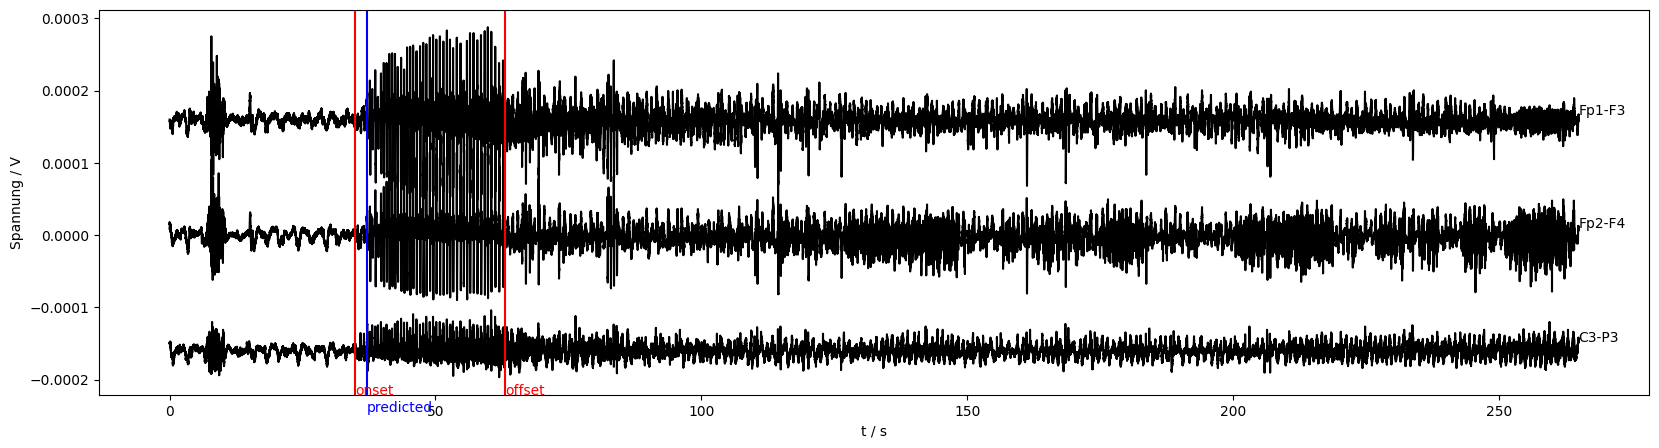

In [9]:
# Wir schauen das Ergebnis auf Basis der Montagen an
fig,axs = plt.subplots(figsize=[20,5])
max_diff=new_data.max()-new_data.min()
time_ax = np.arange(new_data.shape[1])/sampling_frequencies[idx_record]
_off_sets = [max_diff/1.5,0,-max_diff/1.5]
_labels = eeg_labels[idx_record]

for i, _montage in enumerate(new_montage):
    plt.plot(time_ax,new_data[i,:]+_off_sets[i],'k')
    plt.text(time_ax[-1], new_data[i,-1]+_off_sets[i], _montage)
if _labels[0]:
    pred_idx = seizure_id_list.index(ids[idx_record])
    plt.axvline(x = _labels[1], color = 'r', label = 'onset')
    plt.text(_labels[1], axs.get_ylim()[0], 'onset',color='r')  
    plt.axvline(x = _labels[2], color = 'r', label = 'offset')
    plt.text(_labels[2], axs.get_ylim()[0], 'offset',color='r')  
    plt.axvline(x = onset_list_predict[pred_idx], color = 'b', label = 'onset') 
    plt.text(onset_list_predict[pred_idx], axs.get_ylim()[0]-max_diff/10, 'predicted',color='b') 
plt.xlabel("t / s")
plt.ylabel("Spannung / V")
plt.show()

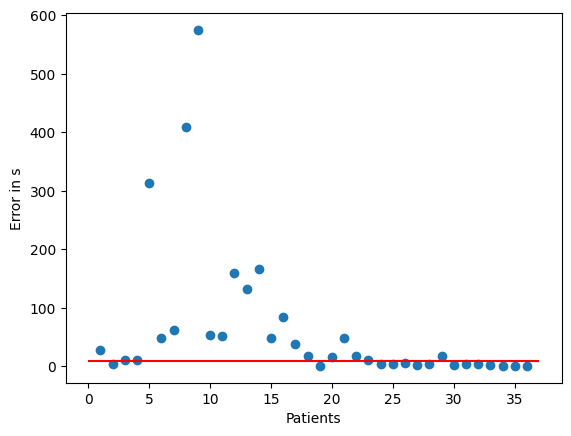

In [10]:
# Zur Verifikation berechnen wir den absoluten Fehler zwischen dem detektierten Seizure Onset und der ground truth basierend auf den Annotationen der Ärzte
prediction_error = np.abs(np.asarray(onset_list_predict) - np.asarray(onset_list))

# Plotte Fehler als Scatterplot
plt.figure(1)
plt.scatter(np.arange(1, len(prediction_error)+1),prediction_error)
plt.hlines(10, 0, len(prediction_error)+1, colors='red')
plt.ylabel('Error in s')
plt.xlabel('Patients')
plt.show()

# Seizure Classification / Detection

In [11]:
# Seizure Detection

feature = []
label = []

for i,_id in enumerate(ids):
    _fs = sampling_frequencies[i]
    _eeg_signals = data[i]
    _eeg_label = eeg_labels[i]
    label.append(_eeg_label[0])
    # Berechne Montage
    _montage, _montage_data, _is_missing = get_3montages(channels[i], _eeg_signals)
    signal_std = np.zeros(len(_montage))
    for j, signal_name in enumerate(_montage):
        # Ziehe erste Montage des EEG
        signal = _montage_data[j]
        # Wende Notch-Filter an um Netzfrequenz zu dämpfen
        signal_notch = mne.filter.notch_filter(x=signal, Fs=_fs, freqs=np.array([50.,100.]), n_jobs=2, verbose=False)
        # Wende Bandpassfilter zwischen 0.5Hz und 70Hz um Rauschen aus dem Signal zu filtern
        signal_filter = mne.filter.filter_data(data=signal_notch, sfreq=_fs, l_freq=0.5, h_freq=70.0, n_jobs=2, verbose=False)
        

        signal_std[j] = np.std(signal_filter)

    # Nur der Kanal mit der maximalen Standardabweichung wird berücksichtigt
    signal_std_max = signal_std.max()
    feature.append(signal_std_max)
    

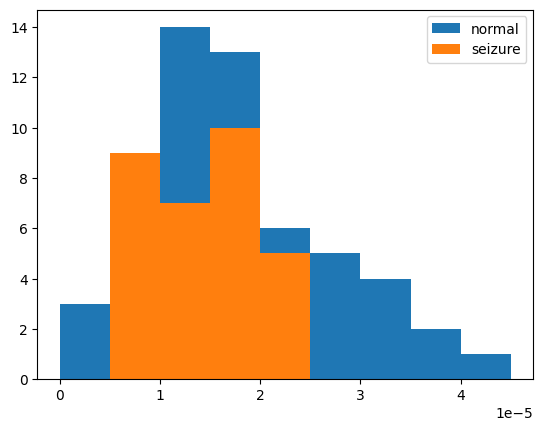

In [12]:
# Veranschaulichung der Verteilung des Features
# Definiere Feature und Label Array
X = np.array(feature)
Y = np.array(label)
# Plotte Histogramme des Features für Normal und Anfall
bins = np.arange(0,0.00005,0.000005)
plt.figure()
plt.hist(X[(Y==0)], bins=bins)
plt.hist(X[Y==1],bins=bins)
plt.legend(['normal','seizure'])

Berechne den besten Threshold per Parameter Sweep

In [13]:
best_f1 = 0
th_opt = 0
for th in np.arange(X.min(),X.max(),(X.max()-X.min())/1e5):
    pred = X>th
    TP = np.sum((pred==Y) & (Y==1))
    FP = np.sum((pred==1) & (Y==0))
    FN = np.sum((pred==0) & (Y==1))
    F1 = 2*TP/(2*TP+FP+FN)  
    if F1 >best_f1:
        th_opt = th
        best_f1 = F1

In [14]:
print('Optimaler Threshold ist', th_opt,' bei F1 auf Trainingsdaten von',best_f1)

Optimaler Threshold ist 4.925801507306835e-06  bei F1 auf Trainingsdaten von 0.5413533834586466
